# Toy Model Demonstration for Eigenpair Tracking

This notebook demonstrates a common issue in tracking eigenvalues and eigenvectors for a one-parameter family of matrices $A(t)$. When eigenvalues are close or cross, a naive application of standard eigensolvers like `numpy.linalg.eigh` can lead to discontinuous eigenvectors. The `eigenpairflow` library is designed to handle this by tracking them continuously.

## 1. The Toy Model

We define a matrix-valued function $A(t)$ by rotating a parameterized diagonal matrix $D(t)$.

The rotation matrix is given by:
$$ R(\theta) = \begin{pmatrix} \cos \theta & -\sin \theta \\ \sin \theta & \cos \theta \end{pmatrix} $$

The diagonal matrix is:
$$ D(t) = \begin{pmatrix} 1 & 0 \\ 0 & 1+t \end{pmatrix} $$

The full matrix function is:
$$ A(t) = R(\theta(t)) D(t) R(\theta(t))^T $$

We choose $\theta(t) = \frac{\pi}{4}t$. The eigenvalues of $A(t)$ are simply the diagonal entries of $D(t)$, which are $\lambda_0(t) = 1$ and $\lambda_1(t) = 1+t$. The corresponding eigenvectors are the columns of $R(\theta(t))$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from eigenpairflow import eigenpairtrack

In [2]:
# Define the toy model
def R_func(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s], [s, c]])

def D_func(t):
    return np.diag([1, 1 + t])

def theta_func(t):
    return np.pi / 4 * t

def A_func(t):
    theta = theta_func(t)
    R = R_func(theta)
    D = D_func(t)
    return R @ D @ R.T

def dtheta_func(t):
    return np.pi / 4

def dR_func(t):
    theta = theta_func(t)
    c, s = np.cos(theta), np.sin(theta)
    return dtheta_func(t) * np.array([[-s, -c], [c, -s]])

def dD_func(t):
    return np.diag([0, 1])

def dA_func(t):
    R = R_func(theta_func(t))
    D = D_func(t)
    dR = dR_func(t)
    dD = dD_func(t)
    return dR @ D @ R.T + R @ dD @ R.T + R @ D @ dR.T

## 2. Naive Eigenvector Calculation

Here, we compute the eigenvectors at each point $t$ independently using `numpy.linalg.eigh`. As the plot will show, the eigenvectors can flip signs, leading to discontinuities.

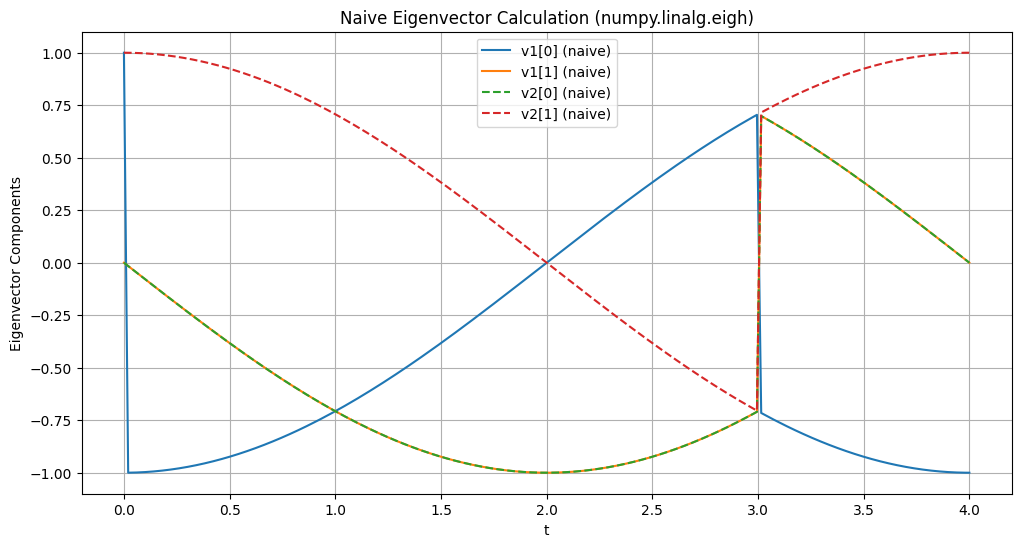

In [3]:
t_space = np.linspace(0, 4, 200)
naive_eigenvectors = []

for t in t_space:
    _, Q = np.linalg.eigh(A_func(t))
    naive_eigenvectors.append(Q)

naive_eigenvectors = np.array(naive_eigenvectors)

plt.figure(figsize=(12, 6))
plt.plot(t_space, naive_eigenvectors[:, 0, 0], label='v1[0] (naive)')
plt.plot(t_space, naive_eigenvectors[:, 1, 0], label='v1[1] (naive)')
plt.plot(t_space, naive_eigenvectors[:, 0, 1], '--', label='v2[0] (naive)')
plt.plot(t_space, naive_eigenvectors[:, 1, 1], '--', label='v2[1] (naive)')
plt.title('Naive Eigenvector Calculation (numpy.linalg.eigh)')
plt.xlabel('t')
plt.ylabel('Eigenvector Components')
plt.legend()
plt.grid(True)
plt.show()

## 3. Continuous Eigenvector Tracking with `eigenpairflow`

Now we use `eigenpairflow.eigenpairtrack()` to track the eigenpairs. This method solves a system of ODEs to ensure the eigenvectors evolve continuously.

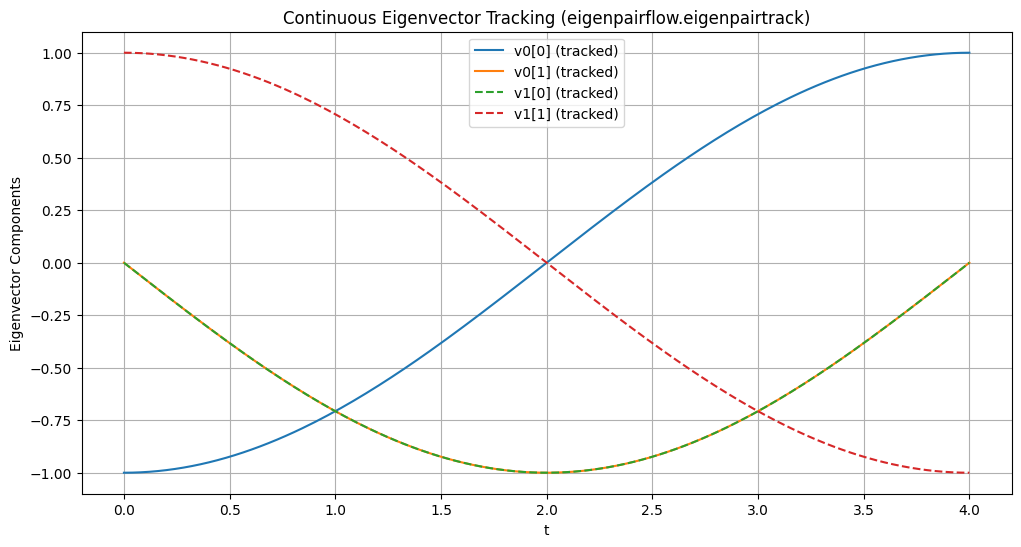

In [4]:
t_start, t_end = 0.0, 4.0
t_eval = np.linspace(t_start, t_end, 200)

results = eigenpairtrack(A_func, dA_func, (t_start, t_end), t_eval)

if results.success:
    tracked_eigenvectors = np.array(results.Qs)
    
    plt.figure(figsize=(12, 6))
    plt.plot(t_space, tracked_eigenvectors[:, 0, 0], label='v0[0] (tracked)')
    plt.plot(t_space, tracked_eigenvectors[:, 1, 0], label='v0[1] (tracked)')
    plt.plot(t_space, tracked_eigenvectors[:, 0, 1], '--', label='v1[0] (tracked)')
    plt.plot(t_space, tracked_eigenvectors[:, 1, 1], '--', label='v1[1] (tracked)')
    plt.title('Continuous Eigenvector Tracking (eigenpairflow.eigenpairtrack)')
    plt.xlabel('t')
    plt.ylabel('Eigenvector Components')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Tracking failed.")